#### Import all the Libraries used

In [1]:
import pandas as pd
import numpy as np

#for visualisations of graphs
import matplotlib.pyplot as plt 
%matplotlib inline

#for datetime object
from datetime import datetime 

#statsmodel libraires
from statsmodels.tsa.stattools import adfuller                 #To check stationarity in Time Series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX         #SARIMA
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import ExponentialSmoothing   #Holt's Winter Method

#ARIMA
from pmdarima import auto_arima

#Skit-Learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")

In [3]:
#Import the monthly rainfall data(from January 1901 to December 1970) for two locations:
# 1. AJMER
ajmer_data  = pd.read_csv("ajmer_rainfall_data.csv") 
# 2. JAIPUR
jaipur_data = pd.read_csv("jaipur_rainfall_data.csv")

In [4]:
ajmer_data.head()

,YEAR,MONTH,Datetime,Rainfall
0,1901,Jan,01-01-1901,5.082
1,1901,Feb,01-02-1901,0.769
2,1901,Mar,01-03-1901,0.182
3,1901,Apr,01-04-1901,0.291
4,1901,May,01-05-1901,3.470


In [5]:
jaipur_data.tail()

,YEAR,MONTH,Datetime,Rainfall
835,1970,Aug,01-08-1970,332.986
836,1970,Sep,01-09-1970,134.737
837,1970,Oct,01-10-1970,0.325
838,1970,Nov,01-11-1970,0.000
839,1970,Dec,01-12-1970,0.000


In [6]:
#Drop year and month column
ajmer_data  = ajmer_data.drop(['YEAR', 'MONTH'], axis=1)
jaipur_data = jaipur_data.drop(['YEAR', 'MONTH'], axis=1)

In [7]:
#Check object types
ajmer_data.dtypes
jaipur_data.dtypes

Datetime     object
Rainfall    float64
dtype: object

In [8]:
#convert object dtype to datetime
ajmer_data['Datetime'] = pd.to_datetime(ajmer_data.Datetime,format='%d-%m-%Y')
jaipur_data['Datetime'] = pd.to_datetime(jaipur_data.Datetime,format='%d-%m-%Y')

In [9]:
#create months column
for i in (ajmer_data, jaipur_data): 
    i['month']=i.Datetime.dt.month 

In [10]:
#check object type
ajmer_data.dtypes
jaipur_data.dtypes

Datetime    datetime64[ns]
Rainfall           float64
month                int64
dtype: object

In [11]:
ajmer_data.head()

,Datetime,Rainfall,month
0,1901-01-01,5.082,1
1,1901-02-01,0.769,2
2,1901-03-01,0.182,3
3,1901-04-01,0.291,4
4,1901-05-01,3.470,5


In [12]:
jaipur_data.tail()

,Datetime,Rainfall,month
835,1970-08-01,332.986,8
836,1970-09-01,134.737,9
837,1970-10-01,0.325,10
838,1970-11-01,0.000,11
839,1970-12-01,0.000,12


### Plot cummulative monthly rainfall

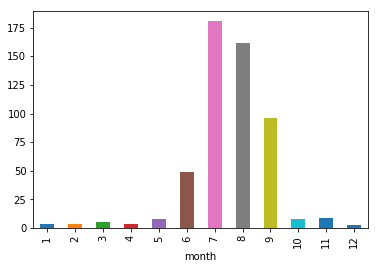

In [13]:
ajmer_data.groupby('month')['Rainfall'].mean().plot.bar()

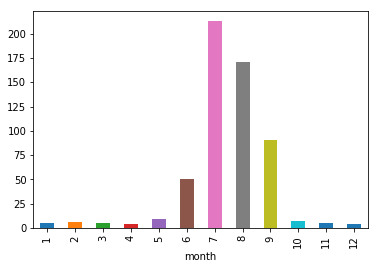

In [14]:
jaipur_data.groupby('month')['Rainfall'].mean().plot.bar()

#### Both the location found to have highest rainfall during JULY and AUGUST

In [15]:
#Create timestamp
ajmer_data.Timestamp = pd.to_datetime(ajmer_data.Datetime,format='%d-%m-%Y') 
ajmer_data.index = ajmer_data.Timestamp 
jaipur_data.Timestamp = pd.to_datetime(jaipur_data.Datetime,format='%d-%m-%Y') 
jaipur_data.index = jaipur_data.Timestamp 

In [16]:
ajmer_data  = ajmer_data.drop(['Datetime','month'], axis=1)
jaipur_data = jaipur_data.drop(['Datetime','month'], axis=1)

In [17]:
ajmer_data.head()

,Rainfall
Datetime,
1901-01-01,5.082
1901-02-01,0.769
1901-03-01,0.182
1901-04-01,0.291
1901-05-01,3.470


In [18]:
jaipur_data.tail()

,Rainfall
Datetime,
1970-08-01,332.986
1970-09-01,134.737
1970-10-01,0.325
1970-11-01,0.000
1970-12-01,0.000


# Visualisations

## Ajmer 

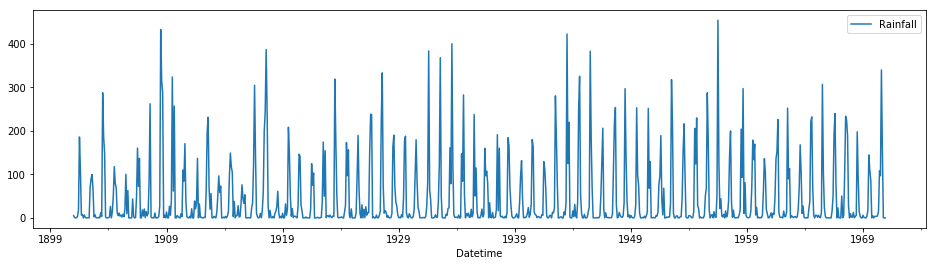

In [27]:
ajmer_data.plot(figsize=(16,4))

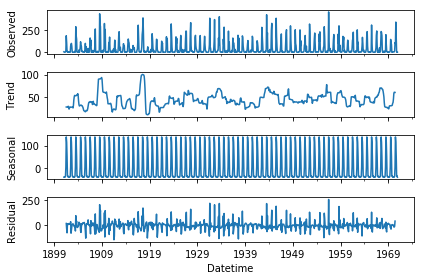

In [28]:
seasonal_decompose(ajmer_data['Rainfall'], model='additive').plot();

### Autocorrelation plot

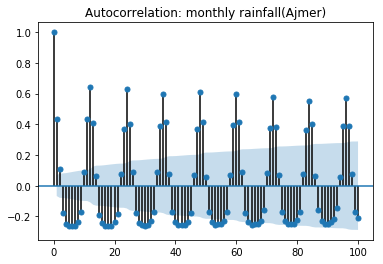

In [29]:
title = 'Autocorrelation: monthly rainfall(Ajmer)'
lags = 100
plot_acf(ajmer_data,title=title,lags=lags);

## Jaipur

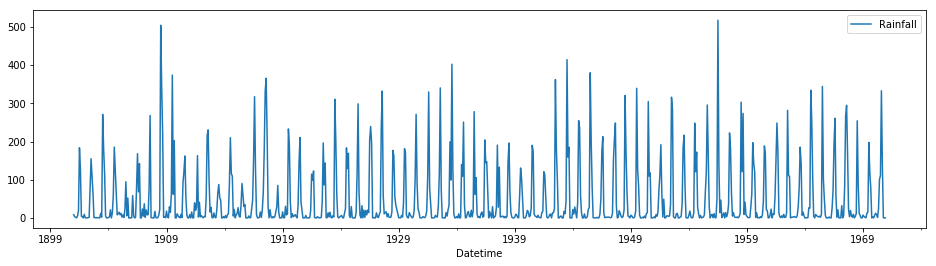

In [30]:
jaipur_data.plot(figsize=(16,4))

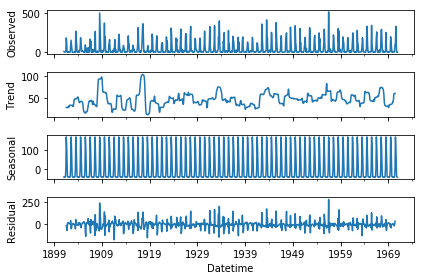

In [31]:
seasonal_decompose(jaipur_data['Rainfall'], model='additive').plot();

### Autocorrelation plot

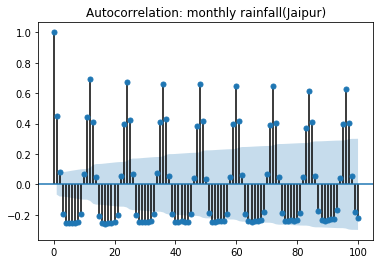

In [32]:
title = 'Autocorrelation: monthly rainfall(Jaipur)'
lags = 100
plot_acf(jaipur_data,title=title,lags=lags);

#### From the visualisaiton data seems to be seasonal.

### Let's check Stationary of the Time Series using Augmented Dickey-Fuller Test

#### Null hypothesis is that datasets are not stationary

In [33]:
print('Augmented Dickey-Fuller Test on Ajmer Rainfall Data')
dftest = adfuller(ajmer_data['Rainfall'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test on Ajmer Rainfall Data


(-7.983073684534115,
 2.5920331501661086e-12,
 21,
 818,
 {'1%': -3.438369485934381,
  '5%': -2.865079774912655,
  '10%': -2.5686548826226527},
 8875.282134374687)

In [34]:
print('Augmented Dickey-Fuller Test on Jaipur Rainfall Data')
dftest = adfuller(jaipur_data['Rainfall'],autolag='AIC')
dftest

Augmented Dickey-Fuller Test on Jaipur Rainfall Data


(-8.149674880455143,
 9.772534997593679e-13,
 21,
 818,
 {'1%': -3.438369485934381,
  '5%': -2.865079774912655,
  '10%': -2.5686548826226527},
 8904.248513465602)

#### Since p-value<0.05, we reject the null hypothesis
#### Hence both the datasets are stationary.

In [54]:
### Train Test Split

In [55]:
len(ajmer_data)
len(jaipur_data)

840

In [57]:
# Set two year for testing

train_a = ajmer_data.iloc[:816]
test_a = ajmer_data.iloc[816:]

train_j = jaipur_data.iloc[:816]
test_j = jaipur_data.iloc[816:]

# MODELS

## 1. ARIMA

### Checks the best fit model ARIMA to be used along with its parameter

In [37]:
stepwise_fit = auto_arima(ajmer_data['Rainfall'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=8933.805, BIC=8952.739, Fit time=2.939 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=9718.228, BIC=9727.695, Fit time=0.051 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=9249.891, BIC=9268.825, Fit time=1.684 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=9416.911, BIC=9435.844, Fit time=1.463 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=9477.511, BIC=9491.711, Fit time=0.650 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=9262.761, BIC=9286.428, Fit time=5.836 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=9259.367, BIC=9273.567, Fit time=1.004 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12); AIC=8996.513, BIC=9020.180, Fit time=9.253 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 2, 12); AIC=8969.693, BIC=8998.093, Fit time=10.222 seconds
Fit ARIMA: order=(1, 0, 0) 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                            
================================================================================
Dep. Variable:                        y   No. Observations:                  840
Model:             SARIMAX(1, 0, 1, 12)   Log Likelihood               -4462.903
Date:                  Sat, 25 Apr 2020   AIC                           8933.805
Time:                          03:21:20   BIC                           8952.739
Sample:                               0   HQIC                          8941.062
                                  - 840                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0300      0.038      0.796      0.426      -0.044       0.104
ar.S.L12       0.9993      0.001   1796.583      0.000       0.998       1.000
ma.S.L12      -0.9599      0.010    -91.932      0.000      -0.980      -0.939
sigma2      2329.4398     56.462     41.257      0.000    2218.777    2440.102
===================================================================================
Ljung-Box (Q):                       37.45   Jarque-Bera (JB):              3468.81
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             2.14
Prob(H) (two-sided):                  0.01   Kurtosis:                        11.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
stepwise_fit = auto_arima(jaipur_data['Rainfall'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=8906.090, BIC=8925.023, Fit time=2.938 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=9825.937, BIC=9835.404, Fit time=0.034 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=9255.201, BIC=9274.135, Fit time=1.550 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=9459.211, BIC=9478.144, Fit time=1.359 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=9540.370, BIC=9554.570, Fit time=0.629 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 1, 12); AIC=8922.454, BIC=8946.121, Fit time=8.545 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=9271.482, BIC=9285.683, Fit time=0.907 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 12); AIC=8963.406, BIC=8987.073, Fit time=8.572 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_orde

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  840
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 12)   Log Likelihood               -4447.590
Date:                            Sat, 25 Apr 2020   AIC                           8905.180
Time:                                    03:18:38   BIC                           8928.847
Sample:                                         0   HQIC                          8914.251
                                            - 840                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0186      0.027      0.692      0.489      -0.034       0.071
ar.L1          0.0558      0.019      2.870      0.004       0.018       0.094
ar.S.L12       0.9996      0.000   3068.369      0.000       0.999       1.000
ma.S.L12      -0.9603      0.009   -105.358      0.000      -0.978      -0.942
sigma2      2227.9284     50.111     44.460      0.000    2129.713    2326.144
===================================================================================
Ljung-Box (Q):                       30.02   Jarque-Bera (JB):              3816.30
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             1.92
Prob(H) (two-sided):                  0.03   Kurtosis:                        12.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Therefore we will use Seasonal-ARIMA model = SARIMAX(0, 0, 0)x(1, 0, 1, 12) for Ajmer Rainfall data
#### and Seasonal-ARIMA model = SARIMAX(1, 0, 0)x(1, 0, 1, 12) for Jaipur Rainfall data

### AJMER

In [42]:
#Fitting our model on Train set

model = SARIMAX(train_a['Rainfall'],order=(0,0,0),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                            
================================================================================
Dep. Variable:                 Rainfall   No. Observations:                  816
Model:             SARIMAX(1, 0, 1, 12)   Log Likelihood               -4337.560
Date:                  Sat, 25 Apr 2020   AIC                           8681.121
Time:                          03:28:42   BIC                           8695.234
Sample:                      01-01-1901   HQIC                          8686.538
                           - 12-01-1968                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9998      0.000   6051.815      0.000       0.999       1.000
ma.S.L12      -0.9701      0.011    -88.841      0.000      -0.991      -0.949
sigma2      2302.5025     53.610     42.949      0.000    2197.428    2407.577
===================================================================================
Ljung-Box (Q):                       37.76   Jarque-Bera (JB):              3269.52
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             2.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
# Obtain predicted values

start=len(train_a)
end=len(train_a)+len(test_a)-1
predicted_a = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,0,0)(1,0,1,12) Predictions')

In [44]:
# Compare predictions to expected values
for i in range(len(predicted_a)):
    print(f"predicted={predicted_a[i]}, expected={test_a['Rainfall'][i]}")

predicted=3.0922658528539775, expected=3.647
predicted=2.578312386497165, expected=0.872
predicted=6.145785271897785, expected=0.312
predicted=3.079611411595638, expected=0.0
predicted=7.387021302687662, expected=4.085
predicted=45.664729734872864, expected=17.160999999999998
predicted=189.21169713776683, expected=144.558
predicted=160.77133685586267, expected=109.52600000000001
predicted=96.44024270998861, expected=86.345
predicted=8.544254233321286, expected=0.0
predicted=9.548422250885578, expected=5.077
predicted=2.460392470931533, expected=0.0
predicted=3.0922658528539775, expected=3.647
predicted=2.577798570669707, expected=3.23
predicted=6.14456051660382, expected=3.967
predicted=3.078997695005676, expected=4.309
predicted=7.385549189190878, expected=15.802
predicted=45.65562949511246, expected=107.89399999999999
predicted=189.17399031634415, expected=96.931
predicted=160.73929773682082, expected=339.50800000000004
predicted=96.4210237342866, expected=152.583
predicted=8.5425515

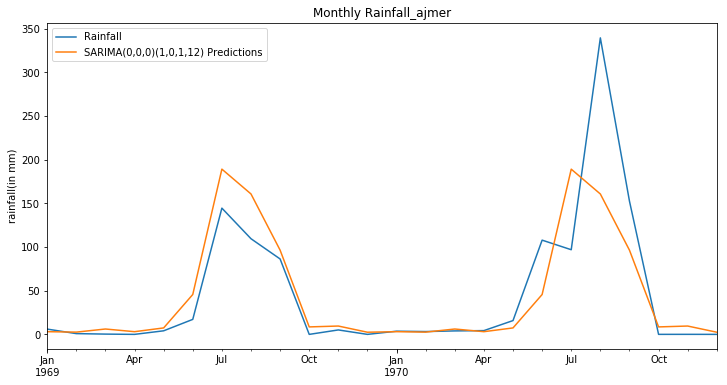

In [45]:
# Plot predictions against known values
title = 'Monthly Rainfall_ajmer'
ylabel='rainfall(in mm)'
xlabel=''

ax = test_a['Rainfall'].plot(legend=True,figsize=(12,6),title=title)
predicted_a.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### Evaluation

In [47]:
error = rmse(test_a['Rainfall'], predicted_a)
print(f'RMSE Error for ARIMA on AJMER rainfall: {error}')

RMSE Error for ARIMA on AJMER rainfall: 47.1881311723501


### JAIPUR

In [49]:
#Fitting our model on Train set

model = SARIMAX(train_j['Rainfall'],order=(1,0,0),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           Rainfall   No. Observations:                  816
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 12)   Log Likelihood               -4323.523
Date:                            Sat, 25 Apr 2020   AIC                           8655.047
Time:                                    03:40:29   BIC                           8673.864
Sample:                                01-01-1901   HQIC                          8662.269
                                     - 12-01-1968                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0640      0.020      3.234      0.001       0.025       0.103
ar.S.L12       0.9997      0.000   5776.755      0.000       0.999       1.000
ma.S.L12      -0.9595      0.009   -105.037      0.000      -0.977      -0.942
sigma2      2220.6290     49.334     45.012      0.000    2123.936    2317.322
===================================================================================
Ljung-Box (Q):                       29.83   Jarque-Bera (JB):              3670.31
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             1.88
Prob(H) (two-sided):                  0.01   Kurtosis:                        12.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
# Obtain predicted values

start=len(train_j)
end=len(train_j)+len(test_j)-1
predicted_j = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,0)(1,0,1,12) Predictions')

In [51]:
# Compare predictions to expected values
for i in range(len(predicted_j)):
    print(f"predicted={predicted_j[i]}, expected={test_j['Rainfall'][i]}")

predicted=5.046457770226148, expected=7.151
predicted=4.870746981667236, expected=3.423
predicted=5.452986841871363, expected=1.838
predicted=3.330029236600022, expected=0.095
predicted=9.298613860362689, expected=12.314
predicted=44.72710428095086, expected=15.245
predicted=229.3397619919928, expected=197.733
predicted=176.04852636753938, expected=118.314
predicted=92.40710837263177, expected=77.801
predicted=8.817009122270044, expected=0.005
predicted=6.274365023059715, expected=2.188
predicted=3.84781989694318, expected=0.0
predicted=5.046457770226148, expected=7.151
predicted=4.8851516990106045, expected=12.081
predicted=5.452494644974293, expected=8.905
predicted=3.3291780806254883, expected=1.194
predicted=9.296061374910986, expected=24.183000000000003
predicted=44.71480705733548, expected=101.271
predicted=229.27670622128977, expected=110.573
predicted=176.00012273209626, expected=332.986
predicted=92.38170151370585, expected=134.737
predicted=8.814584930981477, expected=0.325
p

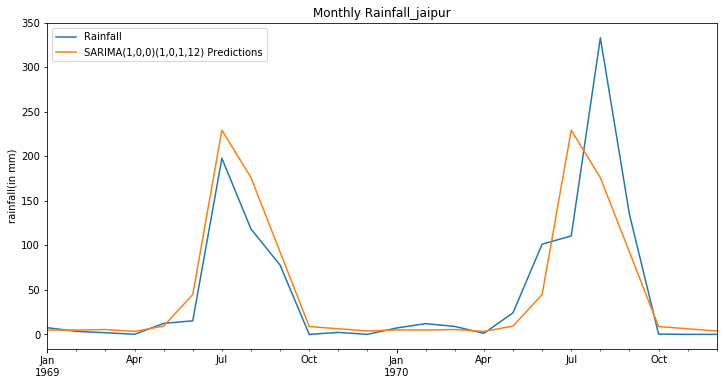

In [52]:
# Plot predictions against known values
title = 'Monthly Rainfall_jaipur'
ylabel='rainfall(in mm)'
xlabel=''

ax = test_j['Rainfall'].plot(legend=True,figsize=(12,6),title=title)
predicted_j.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### Evaluation

In [53]:
error = rmse(test_j['Rainfall'], predicted_j)
print(f'RMSE Error for ARIMA on Jaipur rainfall: {error}')

RMSE Error for ARIMA on AJMER rainfall: 45.51292055359868


## 2. Deep Learning (LSTM)

### AJMER

In [61]:
#Scaled the data

scaler = MinMaxScaler()
scaler.fit(train_a)
scaled_train = scaler.transform(train_a)
scaled_test = scaler.transform(test_a)

In [66]:
# define generator
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [70]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [71]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [72]:
# fit model
model.fit_generator(generator,epochs=50)


Epoch 1/50
792/792 [==============================] - 22s 27ms/step - loss: 0.0262
Epoch 2/50
792/792 [==============================] - 22s 28ms/step - loss: 0.0194
Epoch 3/50
792/792 [==============================] - 22s 28ms/step - loss: 0.0165
Epoch 4/50
792/792 [==============================] - 23s 28ms/step - loss: 0.0164
Epoch 5/50
792/792 [==============================] - 22s 28ms/step - loss: 0.0155
Epoch 6/50
792/792 [==============================] - 22s 28ms/step - loss: 0.0146
Epoch 7/50
792/792 [==============================] - 22s 28ms/step - loss: 0.0145
Epoch 8/50
792/792 [==============================] - 22s 28ms/step - loss: 0.0147
Epoch 9/50
792/792 [==============================] - 21s 27ms/step - loss: 0.0139
Epoch 10/50
792/792 [==============================] - 22s 28ms/step - loss: 0.0150
Epoch 11/50
792/792 [==============================] - 22s 28ms/step - loss: 0.0138
Epoch 12/50
792/792 [==============================] - 22s 28ms/step - loss: 0.0140


In [75]:
model.history.history.keys()

dict_keys(['loss'])

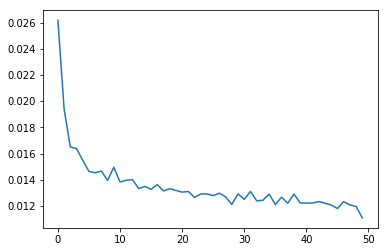

In [76]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [78]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_a)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [79]:
test_predictions

[array([0.00651362], dtype=float32),
 array([0.007817], dtype=float32),
 array([0.01132056], dtype=float32),
 array([0.01201443], dtype=float32),
 array([0.01598825], dtype=float32),
 array([0.05935223], dtype=float32),
 array([0.33002734], dtype=float32),
 array([0.41232616], dtype=float32),
 array([0.24302818], dtype=float32),
 array([0.03781498], dtype=float32),
 array([0.01048656], dtype=float32),
 array([0.00551908], dtype=float32),
 array([0.00531708], dtype=float32),
 array([0.00486092], dtype=float32),
 array([0.00504677], dtype=float32),
 array([0.01039793], dtype=float32),
 array([0.01067961], dtype=float32),
 array([0.03779715], dtype=float32),
 array([0.38908285], dtype=float32),
 array([0.39897668], dtype=float32),
 array([0.22730026], dtype=float32),
 array([0.02401236], dtype=float32),
 array([0.00510409], dtype=float32),
 array([0.00401607], dtype=float32)]

In [80]:
true_predictions = scaler.inverse_transform(test_predictions)

In [81]:
test = test_a
test['Predictions'] = true_predictions

In [82]:
test

,Rainfall,Predictions
Datetime,,
1969-01-01,6.052,2.955326
1969-02-01,0.872,3.546690
1969-03-01,0.312,5.136308
1969-04-01,0.000,5.451129
1969-05-01,4.085,7.254107
1969-06-01,17.161,26.928999
1969-07-01,144.558,149.738355
1969-08-01,109.526,187.078562
1969-09-01,86.345,110.265530


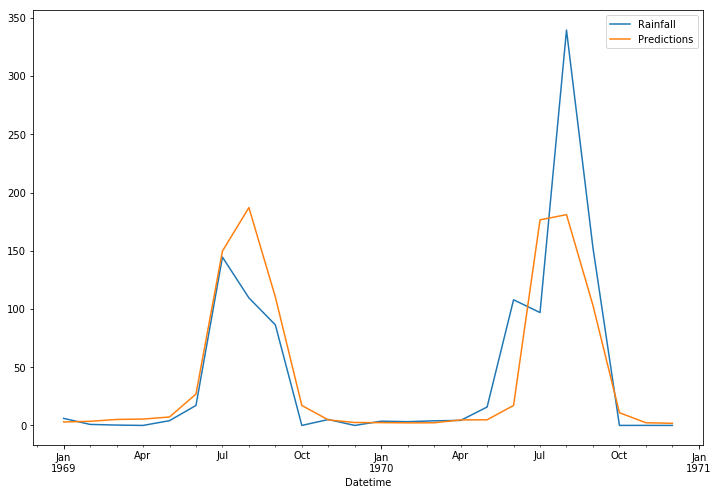

In [83]:
test.plot(figsize=(12,8))

#### Evaluation

In [84]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Rainfall'], test['Predictions'])
print(error)

45.403909924469474


### JAIPUR

In [85]:
#Scaled the data

scaler = MinMaxScaler()
scaler.fit(train_j)
scaled_train = scaler.transform(train_j)
scaled_test = scaler.transform(test_j)

In [86]:
# define generator
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [87]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [88]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [89]:
# fit model
model.fit_generator(generator,epochs=50)

Epoch 1/50
792/792 [==============================] - 22s 28ms/step - loss: 0.0237
Epoch 2/50
792/792 [==============================] - 20s 26ms/step - loss: 0.0146
Epoch 3/50
792/792 [==============================] - 22s 28ms/step - loss: 0.0130
Epoch 4/50
792/792 [==============================] - 23s 29ms/step - loss: 0.0129
Epoch 5/50
792/792 [==============================] - 22s 28ms/step - loss: 0.0122
Epoch 6/50
792/792 [==============================] - 21s 27ms/step - loss: 0.0117
Epoch 7/50
792/792 [==============================] - 21s 26ms/step - loss: 0.0121
Epoch 8/50
792/792 [==============================] - 22s 28ms/step - loss: 0.0110
Epoch 9/50
792/792 [==============================] - 22s 27ms/step - loss: 0.0108 
Epoch 10/50
792/792 [==============================] - 23s 29ms/step - loss: 0.0106
Epoch 11/50
792/792 [==============================] - 22s 28ms/step - loss: 0.0105
Epoch 12/50
792/792 [==============================] - 21s 27ms/step - loss: 0.0107 

In [90]:
model.history.history.keys()

dict_keys(['loss'])

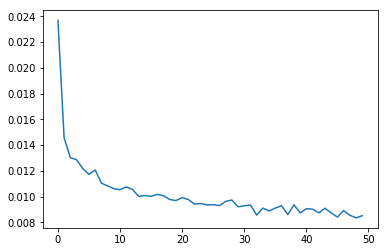

In [91]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [92]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_j)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [93]:
test_predictions

[array([0.01214843], dtype=float32),
 array([0.01267444], dtype=float32),
 array([0.01394684], dtype=float32),
 array([0.01374217], dtype=float32),
 array([0.02596571], dtype=float32),
 array([0.08380789], dtype=float32),
 array([0.4480058], dtype=float32),
 array([0.33491313], dtype=float32),
 array([0.18732813], dtype=float32),
 array([0.02881315], dtype=float32),
 array([0.01184181], dtype=float32),
 array([0.00893158], dtype=float32),
 array([0.0101176], dtype=float32),
 array([0.00941066], dtype=float32),
 array([0.00859991], dtype=float32),
 array([0.0118796], dtype=float32),
 array([0.02253687], dtype=float32),
 array([0.0760466], dtype=float32),
 array([0.43959644], dtype=float32),
 array([0.29995224], dtype=float32),
 array([0.14160097], dtype=float32),
 array([0.01899442], dtype=float32),
 array([0.00833044], dtype=float32),
 array([0.01052609], dtype=float32)]

In [94]:
true_predictions = scaler.inverse_transform(test_predictions)

In [95]:
test = test_j
test['Predictions'] = true_predictions

In [96]:
test

,Rainfall,Predictions
Datetime,,
1969-01-01,7.506,6.288187
1969-02-01,3.423,6.560457
1969-03-01,1.838,7.219065
1969-04-01,0.095,7.113126
1969-05-01,12.314,13.440187
1969-06-01,15.245,43.380051
1969-07-01,197.733,231.893624
1969-08-01,118.314,173.355392
1969-09-01,77.801,96.963475


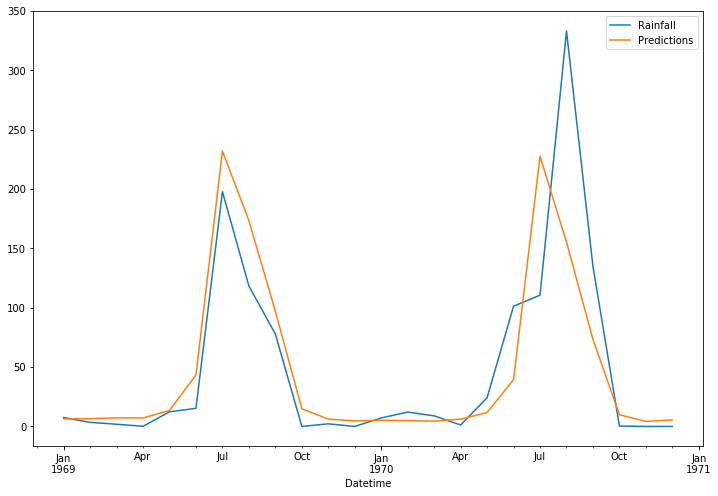

In [97]:
test.plot(figsize=(12,8))

In [108]:
test_a = test_a.drop(['Predictions'], axis=1)
test_j = test_j.drop(['Predictions'], axis=1)

#### Evaluation

In [98]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Rainfall'], test['Predictions'])
print(error)

49.571822230787994


## 3. Holt's Winter Method (Triple Exponential Smoothing)

### AJMER

In [99]:
ajmer_data.index.freq = 'MS'
ajmer_data.index

DatetimeIndex(['1901-01-01', '1901-02-01', '1901-03-01', '1901-04-01',
               '1901-05-01', '1901-06-01', '1901-07-01', '1901-08-01',
               '1901-09-01', '1901-10-01',
               ...
               '1970-03-01', '1970-04-01', '1970-05-01', '1970-06-01',
               '1970-07-01', '1970-08-01', '1970-09-01', '1970-10-01',
               '1970-11-01', '1970-12-01'],
              dtype='datetime64[ns]', name='Datetime', length=840, freq='MS')

In [100]:
fitted_model = ExponentialSmoothing(train_a['Rainfall'],trend='add',seasonal='add',seasonal_periods=12).fit()

In [101]:
test_predictions = fitted_model.forecast(24).rename('HW Forecast')

In [102]:
test_predictions

1969-01-01      3.493738
1969-02-01      2.377296
1969-03-01      7.399685
1969-04-01      2.343780
1969-05-01      6.969326
1969-06-01     42.547826
1969-07-01    198.201694
1969-08-01    161.054606
1969-09-01     95.853950
1969-10-01      7.050945
1969-11-01      7.885954
1969-12-01      0.078353
1970-01-01      0.348095
1970-02-01     -0.768347
1970-03-01      4.254042
1970-04-01     -0.801864
1970-05-01      3.823682
1970-06-01     39.402182
1970-07-01    195.056050
1970-08-01    157.908962
1970-09-01     92.708307
1970-10-01      3.905302
1970-11-01      4.740310
1970-12-01     -3.067291
Freq: MS, Name: HW Forecast, dtype: float64

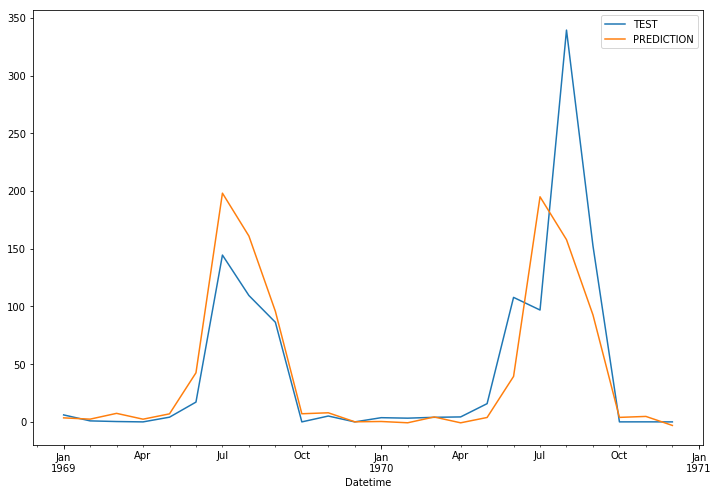

In [103]:
test_a['Rainfall'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

#### Evaluation

,Rainfall,Predictions
Datetime,,
1969-01-01,7.506,6.288187
1969-02-01,3.423,6.560457
1969-03-01,1.838,7.219065
1969-04-01,0.095,7.113126
1969-05-01,12.314,13.440187
1969-06-01,15.245,43.380051
1969-07-01,197.733,231.893624
1969-08-01,118.314,173.355392
1969-09-01,77.801,96.963475


In [109]:
np.sqrt(mean_squared_error(test_a,test_predictions))

48.957564840647855

### JAIPUR

In [110]:
jaipur_data.index.freq = 'MS'
jaipur_data.index

DatetimeIndex(['1901-01-01', '1901-02-01', '1901-03-01', '1901-04-01',
               '1901-05-01', '1901-06-01', '1901-07-01', '1901-08-01',
               '1901-09-01', '1901-10-01',
               ...
               '1970-03-01', '1970-04-01', '1970-05-01', '1970-06-01',
               '1970-07-01', '1970-08-01', '1970-09-01', '1970-10-01',
               '1970-11-01', '1970-12-01'],
              dtype='datetime64[ns]', name='Datetime', length=840, freq='MS')

In [111]:
fitted_model = ExponentialSmoothing(train_j['Rainfall'],trend='add',seasonal='add',seasonal_periods=12).fit()

In [112]:
test_predictions = fitted_model.forecast(24).rename('HW Forecast')

In [113]:
test_predictions

1969-01-01      5.195165
1969-02-01      4.426737
1969-03-01      5.700909
1969-04-01      2.661323
1969-05-01      9.033492
1969-06-01     42.276857
1969-07-01    235.288177
1969-08-01    177.436878
1969-09-01     89.884499
1969-10-01      6.190983
1969-11-01      3.152395
1969-12-01      0.712159
1970-01-01      1.452349
1970-02-01      0.683921
1970-03-01      1.958093
1970-04-01     -1.081493
1970-05-01      5.290676
1970-06-01     38.534041
1970-07-01    231.545361
1970-08-01    173.694062
1970-09-01     86.141684
1970-10-01      2.448168
1970-11-01     -0.590421
1970-12-01     -3.030657
Freq: MS, Name: HW Forecast, dtype: float64

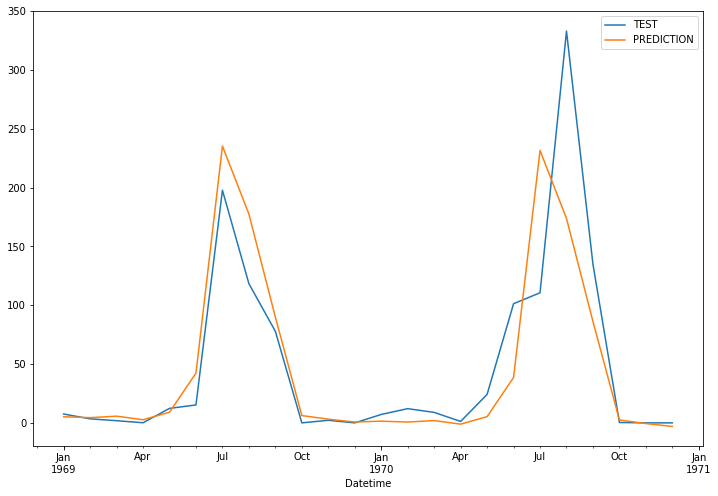

In [114]:
test_j['Rainfall'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

#### Evaluation

In [115]:
np.sqrt(mean_squared_error(test_j,test_predictions))

46.88345048328707

# RESULTS

### RMSE VALUES

#### Ajmer Data
1. ARIMA         = 47.18
2. LSTM          = 45.40
3. Holt's Winter = 48.95

#### Jaipur Data
1. ARIMA         = 45.51
2. LSTM          = 49.57
3. Holt's Winter = 46.88

## Therefore we will choose LSTM on Ajmer Data and ARIMA on Jaipur Data for our future rainfall forecasting

# Forecasting

#### Now we will train our model on all the data from Jan 1901 to Dec 1970

## AJMER (LSTM)

In [19]:
scaler = MinMaxScaler()
scaler.fit(ajmer_data)
scaled_data = scaler.transform(ajmer_data)

In [20]:
# define generator
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_data, scaled_data, length=n_input, batch_size=1)

In [21]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [23]:
# fit model
model.fit_generator(generator,epochs=50)


Epoch 1/50
816/816 [==============================] - 44s 54ms/step - loss: 0.0253
Epoch 2/50
816/816 [==============================] - 45s 56ms/step - loss: 0.0182 0s 
Epoch 3/50
816/816 [==============================] - 44s 54ms/step - loss: 0.0166
Epoch 4/50
816/816 [==============================] - 44s 54ms/step - loss: 0.0158
Epoch 5/50
816/816 [==============================] - 44s 54ms/step - loss: 0.0151
Epoch 6/50
816/816 [==============================] - 44s 54ms/step - loss: 0.0151
Epoch 7/50
816/816 [==============================] - 47s 58ms/step - loss: 0.0143
Epoch 8/50
816/816 [==============================] - 43s 53ms/step - loss: 0.0147
Epoch 9/50
816/816 [==============================] - 42s 51ms/step - loss: 0.0140
Epoch 10/50
816/816 [==============================] - 42s 51ms/step - loss: 0.0141
Epoch 11/50
816/816 [==============================] - 42s 51ms/step - loss: 0.0137
Epoch 12/50
816/816 [==============================] - 41s 51ms/step - loss: 0.0

In [24]:
model.history.history.keys()

dict_keys(['loss'])

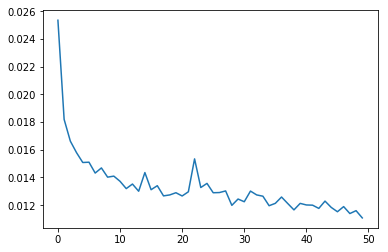

In [25]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [26]:
Forecasted_rainfall = []

first_eval_batch = scaled_data[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(1,361):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    Forecasted_rainfall.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [55]:
Rainfall_Ajmer = scaler.inverse_transform(Forecasted_rainfall)

In [60]:
Rainfall_Ajmer

array([[  4.89238599],
       [  4.72297523],
       [  5.34533455],
       [  3.24663559],
       [  0.28728671],
       [ 18.74473515],
       [263.40879335],
       [185.45614039],
       [ 83.69698087],
       [  5.2449828 ],
       [  2.53430248],
       [  2.08291906],
       [  2.91839485],
       [  2.89045889],
       [  3.84465574],
       [  4.59662114],
       [  4.19713424],
       [ 13.27979894],
       [115.54952999],
       [181.96563308],
       [ 87.35648315],
       [ -0.6470771 ],
       [  1.77537338],
       [  2.15520978],
       [  2.79663816],
       [  2.87799859],
       [  3.24725759],
       [  3.45224749],
       [  3.06293233],
       [  1.36964619],
       [170.97168441],
       [162.69858443],
       [ 87.93705346],
       [  0.75064364],
       [  1.80747404],
       [  2.6847253 ],
       [  3.07104201],
       [  3.09625333],
       [  3.45914358],
       [  4.3284711 ],
       [  3.17291495],
       [  1.86362991],
       [133.38251479],
       [163

In [56]:
#created a file with no values initially then later delete it
forecasted_ajmer = pd.read_csv("Forecasted_Ajmer.csv")

In [57]:
forecasted_ajmer['Rainfall']=Rainfall_Ajmer

In [61]:
forecasted_ajmer.to_csv('Ajmer_forecasted.csv',index=False)

## JAIPUR(ARIMA)

In [62]:
#Fitting our model on whole dataset

model = SARIMAX(jaipur_data['Rainfall'],order=(1,0,0),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           Rainfall   No. Observations:                  840
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 12)   Log Likelihood               -4449.753
Date:                            Sat, 25 Apr 2020   AIC                           8907.507
Time:                                    09:12:58   BIC                           8926.440
Sample:                                01-01-1901   HQIC                          8914.763
                                     - 12-01-1970                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0550      0.019      2.895      0.004       0.018       0.092
ar.S.L12       0.9998      0.000   6731.256      0.000       0.999       1.000
ma.S.L12      -0.9640      0.009   -107.231      0.000      -0.982      -0.946
sigma2      2218.8975     48.775     45.492      0.000    2123.300    2314.495
===================================================================================
Ljung-Box (Q):                       29.94   Jarque-Bera (JB):              3733.15
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             1.88
Prob(H) (two-sided):                  0.03   Kurtosis:                        12.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
# Obtain predicted values

start=len(jaipur_data)
end=len(jaipur_data)+360-1
Rainfall_Jaipur = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,0,0)(1,0,1,12) Predictions')

In [64]:
Rainfall_Jaipur

1971-01-01      5.054592
1971-02-01      5.256650
1971-03-01      5.356260
1971-04-01      3.279310
1971-05-01      9.946390
1971-06-01     46.366806
1971-07-01    221.985689
1971-08-01    178.809440
1971-09-01     93.012767
1971-10-01      8.066751
1971-11-01      5.831988
1971-12-01      3.609606
1972-01-01      5.252019
1972-02-01      5.266418
1972-03-01      5.355687
1972-04-01      3.278625
1972-05-01      9.944212
1972-06-01     46.356644
1972-07-01    221.937040
1972-08-01    178.770253
1972-09-01     92.992382
1972-10-01      8.064983
1972-11-01      5.830710
1972-12-01      3.608815
1973-01-01      5.250868
1973-02-01      5.265264
1973-03-01      5.354513
1973-04-01      3.277906
1973-05-01      9.942033
1973-06-01     46.346485
                 ...    
1998-07-01    220.675889
1998-08-01    177.754396
1998-09-01     92.463956
1998-10-01      8.019154
1998-11-01      5.797577
1998-12-01      3.588308
1999-01-01      5.221030
1999-02-01      5.235344
1999-03-01      5.324086


In [65]:
Rainfall_Jaipur.to_csv('Jaipur_forecasted.csv',index=False)